# Abgabe Digitale Bildverarbeitung
Simon Ball

In diesem Notebook werden einige verschiedene Konzepte aufgegriffen, die die drei Metriken

To Do:

*   Kommentare hinzufügen
*   Hinweis zu auskommentieren von google drive dingen + wandb



### Zusätzliche Pakete installieren



In [ ]:
!pip install wandb -q
!pip install Augmentor -q

###Imports

In [2]:
import Augmentor
import datetime
import math
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.decomposition  import PCA
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, BatchNormalization, Activation, Flatten, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

# Uncomment the following lines to use weights and biases
# import wandb
# from wandb.keras import WandbMetricsLogger

# Uncomment the following lines to mount Google Drive in Google Colab
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Daten laden, reduzieren und anzeigen

x_train: (1000, 28, 28, 1)
y_train: (1000,)
x_test: (10000, 28, 28, 1)
y_test: (10000,)

 Plot of the first 25 samples in the MNIST training set


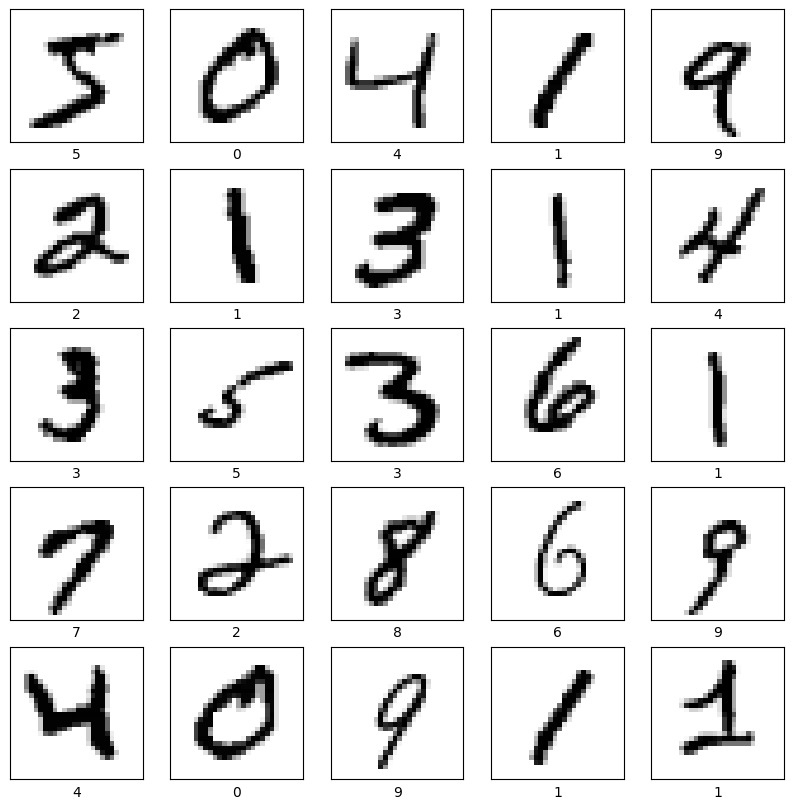

In [3]:
(x_train_entire, y_train_entire), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Reshape Data
x_train_entire = x_train_entire.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

# Reduce Data to 1000 Samples
x_train = x_train_entire[:1000]
y_train = y_train_entire[:1000]

# Printing the shape
print('x_train:', x_train.shape)
print('y_train:', y_train.shape)
print('x_test:', x_test.shape)
print('y_test:', y_test.shape)

# Plotting data samples
print('\n Plot of the first 25 samples in the MNIST training set')
numbers_to_display = 25
num_cells = math.ceil(math.sqrt(numbers_to_display))
plt.figure(figsize=(10,10))
for i in range(numbers_to_display):
    plt.subplot(num_cells, num_cells, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap=plt.cm.binary)
    plt.xlabel(y_train[i])
plt.show()

## 1. Data Augmentation

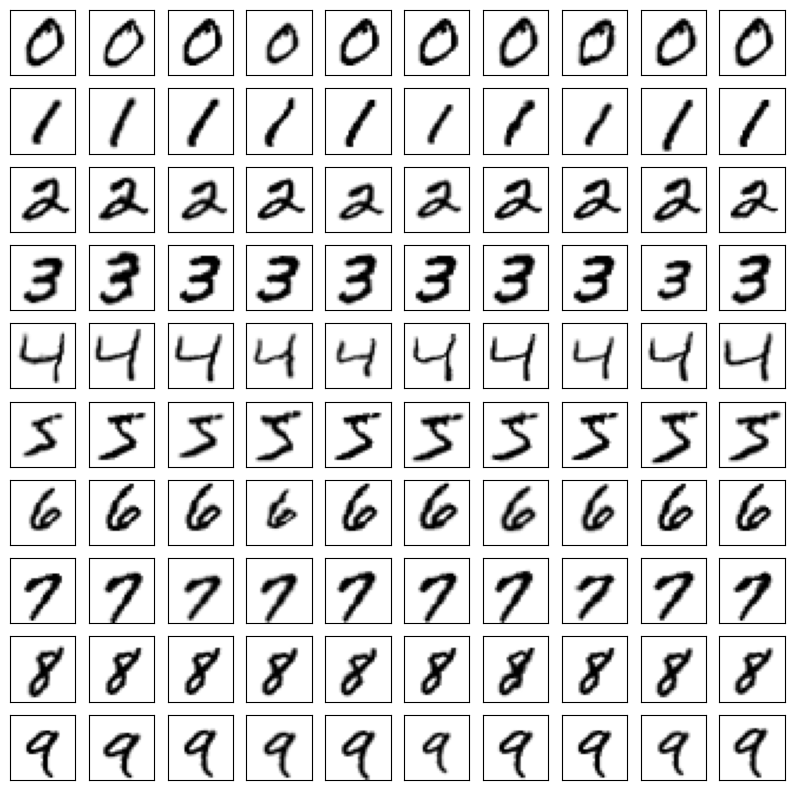

In [4]:
# Define the Pipeline
augmentor_pipeline = Augmentor.Pipeline()
augmentor_pipeline.rotate_without_crop(probability=0.2, max_left_rotation=5, max_right_rotation=5, fillcolor=0)
augmentor_pipeline.random_distortion(probability=0.2, grid_width=6, grid_height=6, magnitude=1)
augmentor_pipeline.zoom(probability=0.2, min_factor=0.8, max_factor=1.0)
augmentor_pipeline.skew(probability=0.2, magnitude=0.1)

# Plot ten augmentations of each digit
plt.figure(figsize=(10,10))
for digit in range(10):
  digit_index = np.where(y_train == digit)[0][0]
  image_generator = augmentor_pipeline.keras_generator_from_array(x_train[digit_index:digit_index+1], y_train[digit_index:digit_index+1], batch_size=10, scaled=True)
  x_train_aug, y_train_aug = next(image_generator)
  for number in range(10):
      plt.subplot(10, 10, digit*10 + number + 1)
      plt.xticks([])
      plt.yticks([])
      plt.grid(False)
      plt.imshow(x_train_aug[number], cmap=plt.cm.binary)
plt.show()

# Generate the generator object for training
image_generator = augmentor_pipeline.keras_generator_from_array(x_train, y_train, batch_size=1024, scaled=True)

## 2. Convolutional Neural Network

In [5]:
# Try to make the results repeatable
tf.keras.utils.set_random_seed(42)

# Prepare weights and biases / set parameters
# wandb.init(
#     project="CNN",
#     config={
#         "labels": 1000,
#         "epochs": 100
#     }
# )

# Define the model
model_conv = Sequential([
    Conv2D(filters=32, kernel_size=(5,5), strides=1, activation='relu', input_shape=(28, 28,1)),
    MaxPooling2D(pool_size=2, strides=2, padding='same'),
    Conv2D(filters=16, kernel_size=(5,5), strides=1, activation='relu'),
    MaxPooling2D(pool_size=2, strides=2, padding='same'),
    BatchNormalization(),
    Activation("relu"),
    Flatten(),
    Dense(units=64, activation='relu'),
    Dropout(rate=0.3),
    Dense(units=10, activation='softmax')
])

# Compile model
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
model_conv.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=loss_fn,
              metrics=['accuracy'])


# Define Callbacks
reduce_lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_accuracy",
    factor=0.2,
    patience=10,
    min_lr=0.0
)
# checkpoint_filepath = f'./drive/MyDrive/MNIST/checkpoints/model_{datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")}.h5' # Used for Google Drive
checkpoint_filepath = f'model_{datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")}.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

# Train model
model_conv.fit(
    image_generator,
    steps_per_epoch=1,
    epochs=100, # wandb.config["epochs"],
    validation_data=(x_test, y_test),
    callbacks=[
        model_checkpoint_callback,
        reduce_lr_callback,
        # WandbMetricsLogger()
        ]
)

# Show model configuration
model_conv.summary()

# Evaluate best epoch and rename weights file
model = tf.keras.models.load_model(checkpoint_filepath)
results = model.evaluate(x_test, y_test)
print(f"test loss: {results[0]}, test acc: {results[1]}")
os.rename(checkpoint_filepath, f"{checkpoint_filepath[:-3]}_{results[1]:.4f}.h5")

# wandb.finish()

wandb: Currently logged in as: ballsimon (mnist_project). Use `wandb login --relogin` to force relogin


Epoch 1/100
1/1 [==============================] - 7s 7s/step - loss: 2.5239 - accuracy: 0.1055 - val_loss: 17.0109 - val_accuracy: 0.1649 - lr: 0.0010
Epoch 2/100
1/1 [==============================] - ETA: 0s - loss: 2.3138 - accuracy: 0.1484

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 3s 3s/step - loss: 2.3138 - accuracy: 0.1484 - val_loss: 13.7698 - val_accuracy: 0.2053 - lr: 0.0010
Epoch 3/100
1/1 [==============================] - 1s 1s/step - loss: 2.1540 - accuracy: 0.2188 - val_loss: 11.7407 - val_accuracy: 0.2482 - lr: 0.0010
Epoch 4/100
1/1 [==============================] - 1s 1s/step - loss: 2.0467 - accuracy: 0.2441 - val_loss: 10.2557 - val_accuracy: 0.2973 - lr: 0.0010
Epoch 5/100
1/1 [==============================] - 1s 1s/step - loss: 1.9160 - accuracy: 0.3213 - val_loss: 9.3740 - val_accuracy: 0.3452 - lr: 0.0010
Epoch 6/100
1/1 [==============================] - 1s 1s/step - loss: 1.8485 - accuracy: 0.3730 - val_loss: 8.4161 - val_accuracy: 0.4022 - lr: 0.0010
Epoch 7/100
1/1 [==============================] - 1s 1s/step - loss: 1.7518 - accuracy: 0.4082 - val_loss: 7.5586 - val_accuracy: 0.4524 - lr: 0.0010
Epoch 8/100
1/1 [==============================] - 1s 1s/step - loss: 1.6943 - accuracy: 0.4746 - val_l

epoch/accuracy,▁▂▃▄▅▅▆▆▆▇▇▇▇▇▇▇█▇██████████████████████
epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
epoch/learning_rate,█████████████████████████████████████▁▁▁
epoch/loss,█▇▆▆▅▄▄▃▃▃▃▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/lr,█████████████████████████████████████▁▁▁
epoch/val_accuracy,▁▂▃▄▅▆▆▆▆▇▇▇▇▇▇█▇███████████████████████
epoch/val_loss,█▅▃▃▂▂▂▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/accuracy,0.97656
epoch/epoch,99
epoch/learning_rate,0.0002
epoch/loss,0.09635


## 2.2 Monte Carlo Dropout

In [6]:
# Predict test data 100 times and store probabilities
y_probas = np.stack([model(x_test,training=True) for sample in range(100)])

# Calculate mean of each digit and probability
y_probas_mean = y_probas.mean(axis=0)

# Get highes probability prediction for each sample
y_pred = np.argmax(y_probas_mean,axis=1)

# Calculate the accuracy of the model
accuracy = sum(y_pred == y_test) / len(y_test)
print(f"Test Accuracy: {accuracy}")

Test Accuracy: 0.9553


## 3. Neuronales Netz mit vorgeschaltener Principal Component Analysis (PCA)

In [7]:
# Flatten the data
x_train_entire_flattened = x_train_entire.reshape((x_train_entire.shape[0], -1))
x_train_flattened = x_train.reshape((x_train.shape[0], -1))
x_test_flattened = x_test.reshape((x_test.shape[0], -1))

# Execute the PCA
pca = PCA(n_components=50)
pca.fit(x_train_entire_flattened)
x_train_pca = pca.transform(x_train_flattened)
x_test_pca = pca.transform(x_test_flattened)

In [8]:
# Try to make the results repeatable
tf.keras.utils.set_random_seed(42)

# Prepare weights and biases / set parameters
# wandb.init(
#     project="PCA",
#     config={
#         "labels": 1000,
#         "epochs": 100
#     }
# )

# Define the model
model_pca = Sequential([
    Dense(64, activation='relu'),
    Dense(10, activation='softmax')
])

# Compile model
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
model_pca.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
              loss=loss_fn,
              metrics=['accuracy'])

# Define Callbacks
reduce_lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_accuracy",
    factor=0.2,
    patience=10,
    min_lr=0.0
)
# checkpoint_filepath = f'./drive/MyDrive/MNIST/checkpoints/model_{datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")}.h5' # Used for Google Drive
checkpoint_filepath = f'model_{datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")}.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

# Train model
model_pca.fit(
    x_train_pca,
    y_train,
    batch_size=1024,
    steps_per_epoch=1,
    epochs=100, # wandb.config["epochs"],
    validation_data=(x_test_pca, y_test),
    callbacks=[
        model_checkpoint_callback,
        reduce_lr_callback,
        # WandbMetricsLogger()
        ]
)

# Show model configuration
model_pca.summary()

# Evaluate best epoch and rename weights file
model_pca = tf.keras.models.load_model(checkpoint_filepath)
results = model_pca.evaluate(x_test_pca, y_test)
print(f"test loss: {results[0]}, test acc: {results[1]}")
os.rename(checkpoint_filepath, f"{checkpoint_filepath[:-3]}_{results[1]:.4f}.h5")

# wandb.finish()

Epoch 1/100
1/1 [==============================] - 1s 992ms/step - loss: 316.5688 - accuracy: 0.0730 - val_loss: 212.6331 - val_accuracy: 0.1315 - lr: 0.0100
Epoch 2/100
1/1 [==============================] - 0s 73ms/step - loss: 195.0087 - accuracy: 0.1290 - val_loss: 139.7835 - val_accuracy: 0.2374 - lr: 0.0100
Epoch 3/100
1/1 [==============================] - ETA: 0s - loss: 111.3541 - accuracy: 0.2890

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 138ms/step - loss: 111.3541 - accuracy: 0.2890 - val_loss: 92.9140 - val_accuracy: 0.3853 - lr: 0.0100
Epoch 4/100
1/1 [==============================] - 0s 127ms/step - loss: 65.5041 - accuracy: 0.4950 - val_loss: 64.9512 - val_accuracy: 0.5274 - lr: 0.0100
Epoch 5/100
1/1 [==============================] - 0s 132ms/step - loss: 41.2878 - accuracy: 0.6500 - val_loss: 48.8640 - val_accuracy: 0.6260 - lr: 0.0100
Epoch 6/100
1/1 [==============================] - 0s 132ms/step - loss: 28.9039 - accuracy: 0.7490 - val_loss: 39.9922 - val_accuracy: 0.6888 - lr: 0.0100
Epoch 7/100
1/1 [==============================] - 0s 138ms/step - loss: 21.5068 - accuracy: 0.7990 - val_loss: 35.0595 - val_accuracy: 0.7309 - lr: 0.0100
Epoch 8/100
1/1 [==============================] - 0s 206ms/step - loss: 16.9895 - accuracy: 0.8340 - val_loss: 32.2593 - val_accuracy: 0.7565 - lr: 0.0100
Epoch 9/100
1/1 [==============================] - 0s 100ms/step - loss: 13

epoch/accuracy,▁▃▆▇▇▇▇█████████████████████████████████
epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
epoch/learning_rate,███████████████▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/lr,████████████████▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_accuracy,▁▄▇▇████████████████████████████████████
epoch/val_loss,█▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/accuracy,1.0
epoch/epoch,99
epoch/learning_rate,0.0
epoch/loss,6e-05


## 4. Backbone bzw. Transfer Learning
Code angepasst von https://www.hackersrealm.net/post/transfer-learning-using-pretrained-model-python

In [9]:
# code adapted from https://www.hackersrealm.net/post/transfer-learning-using-pretrained-model-python
x_train_transfer = x_train.astype('float32')
x_test_transfer = x_test.astype('float32')

# convert data to 3 channels
x_train_transfer = np.repeat(x_train_transfer, repeats=3, axis=-1)
x_test_transfer = np.repeat(x_test_transfer, repeats=3, axis=-1)

# convert labels to be an array rather than a single number
y_train_transfer = to_categorical(y_train)
y_test_transfer = to_categorical(y_test)

# data augmentation with generator
train_generator = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 40,
    shear_range = 0.2,
    zoom_range = 0.2,
    fill_mode = 'nearest'
)
val_generator = ImageDataGenerator(rescale = 1./255)

# Create iterators
train_iterator = train_generator.flow(x_train_transfer, y_train_transfer, batch_size=512, shuffle=True)
val_iterator = val_generator.flow(x_test_transfer, y_test_transfer, batch_size=512, shuffle=False)


In [13]:
# Try to make the results repeatable
tf.keras.utils.set_random_seed(42)

# Prepare weights and biases / set parameters
# wandb.init(
#     project="ResNet",
#     config={
#         "labels": 1000,
#         "epochs": 100
#     }
# )

# Define the model with the pretrained weights
model_resnet = Sequential([
    ResNet50(include_top=False, pooling='avg', weights='imagenet'),
    Dense(512, activation='relu'),
    Dense(10, activation='softmax')
])

# set resnet layers to be not trainable
model_resnet.layers[0].trainable=False

# Compile model
loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=False)
model_resnet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=loss_fn,
              metrics=['accuracy'])

# Define Callbacks
reduce_lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_accuracy",
    factor=0.2,
    patience=10,
    min_lr=0.0
)
# checkpoint_filepath = f'./drive/MyDrive/MNIST/checkpoints/model_{datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")}.h5' # Used for Google Drive
checkpoint_filepath = f'model_{datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")}.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

# Train model
model_resnet.fit(
    train_iterator,
    epochs = 100, # wandb.config["epochs"],
    validation_data=val_iterator,
    callbacks=[
        model_checkpoint_callback,
        reduce_lr_callback,
        # WandbMetricsLogger()
        ]
)

# Show model configuration
model_resnet.summary()

# Evaluate best epoch and rename weights file
model_resnet = tf.keras.models.load_model(checkpoint_filepath)
results = model_resnet.evaluate(val_iterator)
print(f"test loss: {results[0]}, test acc: {results[1]}")
os.rename(checkpoint_filepath, f"{checkpoint_filepath[:-3]}_{results[1]:.4f}.h5")

# wandb.finish()

epoch/accuracy,▁▂▂▄▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇████████████
epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
epoch/learning_rate,████████████████████████████████████▁▁▁▁
epoch/loss,█▇▆▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
epoch/lr,████████████████████████████████████▁▁▁▁
epoch/val_accuracy,▁▂▂▅▆▆▆▆▇▆▇▇▇▇▇▇▇▇█▇▇███████████████████
epoch/val_loss,█▇▆▆▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/accuracy,0.751
epoch/epoch,99
epoch/learning_rate,0.0002
epoch/loss,0.82804


Epoch 1/100
2/2 [==============================] - ETA: 0s - loss: 2.6280 - accuracy: 0.1130

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 8s 4s/step - loss: 2.6280 - accuracy: 0.1130 - val_loss: 2.3644 - val_accuracy: 0.2344 - lr: 0.0010
Epoch 2/100
2/2 [==============================] - 2s 1s/step - loss: 2.4489 - accuracy: 0.1820 - val_loss: 2.3796 - val_accuracy: 0.1812 - lr: 0.0010
Epoch 3/100
2/2 [==============================] - 2s 2s/step - loss: 2.3599 - accuracy: 0.2580 - val_loss: 2.1507 - val_accuracy: 0.2973 - lr: 0.0010
Epoch 4/100
2/2 [==============================] - 2s 2s/step - loss: 2.1964 - accuracy: 0.2730 - val_loss: 2.0262 - val_accuracy: 0.3506 - lr: 0.0010
Epoch 5/100
2/2 [==============================] - 2s 1s/step - loss: 2.0872 - accuracy: 0.3020 - val_loss: 1.9752 - val_accuracy: 0.2180 - lr: 0.0010
Epoch 6/100
2/2 [==============================] - 2s 1s/step - loss: 2.0637 - accuracy: 0.1940 - val_loss: 1.9014 - val_accuracy: 0.2656 - lr: 0.0010
Epoch 7/100
2/2 [==============================] - 3s 2s/step - loss: 1.9768 - accuracy: 0.2870 - val_loss

epoch/accuracy,▁▃▂▄▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇████████████
epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
epoch/learning_rate,█████████████████████████████████▂▂▂▂▁▁▁
epoch/loss,█▇▆▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/lr,██████████████████████████████████▂▂▂▂▁▁
epoch/val_accuracy,▁▂▁▅▆▆▆▆▆▇▇▇▇▇▇▇█▇▇█▇▇█████▇▇███████████
epoch/val_loss,█▇▆▅▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/accuracy,0.764
epoch/epoch,99
epoch/learning_rate,4e-05
epoch/loss,0.82719
